# Stroke Prediction Modeling Part

In [77]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [78]:
import functions as myFunc

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import (
    StandardScaler,
    OrdinalEncoder,
    OneHotEncoder,
)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report
from sklearn import set_config
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import (
    LogisticRegression,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score,
    recall_score,
    classification_report,
)
from sklearn.model_selection import (
    cross_validate,
    StratifiedKFold,
    GridSearchCV,
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import shap
from joblib import dump

In [79]:
pd.set_option("float_format", "{:.2f}".format)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
set_config(display="diagram")

In [80]:
df = pd.read_csv(
    r"C:\Users\jonyt\Python\3 module\sprint 2\project\healthcare-dataset-stroke-data.csv"
)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [81]:
df.replace({"hypertension": {1: "yes", 0: "no"}}, inplace=True)
df.replace({"heart_disease": {1: "yes", 0: "no"}}, inplace=True)
df.columns = df.columns.str.lower()
df = df.apply(lambda x: x.str.lower() if (x.dtype == "object") else x)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,male,67.00,no,yes,yes,private,urban,228.69,36.60,formerly smoked,1
1,51676,female,61.00,no,no,yes,self-employed,rural,202.21,NaN,never smoked,1
2,31112,male,80.00,no,yes,yes,private,rural,105.92,32.50,never smoked,1
3,60182,female,49.00,no,no,yes,private,urban,171.23,34.40,smokes,1
4,1665,female,79.00,yes,no,yes,self-employed,rural,174.12,24.00,never smoked,1


In [82]:
# 70% train,   30% (valid+train)
df_train, df_val_and_test = train_test_split(
    df, test_size=0.3, random_state=1, stratify=df["stroke"]
)

In [83]:
# 50% test,   50% valid
df_test, df_valid = train_test_split(
    df_val_and_test,
    test_size=0.5,
    random_state=1,
    stratify=df_val_and_test["stroke"],
)

In [84]:
X_train = df_train.drop(["stroke", "id"], axis=1)
y_train = df_train["stroke"]
X_val = df_valid.drop(["stroke", "id"], axis=1)
y_val = df_valid["stroke"]
X_test = df_test.drop(["stroke", "id"], axis=1)
y_test = df_test["stroke"]

In [85]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3577, 10), (3577,), (767, 10), (767,), (766, 10), (766,))

In [86]:
y_train.value_counts()

0    3403
1     174
Name: stroke, dtype: int64

In [87]:
y_val.value_counts()

0    729
1     38
Name: stroke, dtype: int64

In [88]:
y_test.value_counts()

0    729
1     37
Name: stroke, dtype: int64

**Splitting columns into 3 categories**

In [89]:
one_hot_features = [
    "work_type",
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "residence_type",
]

ordinal_features = ["smoking_status"]

numerical_features = ["bmi", "age", "avg_glucose_level"]

**Feature engineering**

In [90]:
# def get_bmi_times_glucose(df):
#     df["bmi_times_glucose"] = df["bmi"] * df["avg_glucose_level"]
#     return df.drop(["bmi", "avg_glucose_level"], axis=1)


# def get_age2_per_bmi(df):
#     df["glucose_per_age"] = df["age"] * df["age"] / df["bmi"]
#     return df.drop(["age", "bmi"], axis=1)

In [91]:
feature_engineering_pipe = Pipeline(
    [
        (
            "new_features",
            ColumnTransformer(
                [
                    (
                        "bmi_times_glucose",
                        FunctionTransformer(
                            myFunc.get_bmi_times_glucose, validate=False
                        ),
                        ["bmi", "avg_glucose_level"],
                    ),
                    (
                        "age2_per_bmi",
                        FunctionTransformer(myFunc.get_age2_per_bmi, validate=False),
                        ["age", "bmi"],
                    ),
                ]
            ),
        ),
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

In [92]:
# testing feature engineering pipeline
test = feature_engineering_pipe.fit_transform(X_train)
test_df = pd.DataFrame(test, columns=["bmi_times_glucose", "age2_per_bmi"])
test_df.head()

,bmi_times_glucose,age2_per_bmi
0,-0.47,-0.26
1,0.59,0.52
2,-0.21,-0.04
3,-0.49,-0.60
4,0.32,-0.17


In [93]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

In [94]:
one_hot_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]
)

In [95]:
cat_lvl = [["never smoked", "unknown", "formerly smoked", "smokes"]]

ordinal_transformer = make_column_transformer(
    (
        OrdinalEncoder(
            categories=cat_lvl, handle_unknown="use_encoded_value", unknown_value=-9999
        ),
        ["smoking_status"],
    ),
)

# testing ordinal encoder transformer
new_smoke = pd.DataFrame(
    ordinal_transformer.fit_transform(X_train),
    columns=["smoke"],
)
new_smoke.head()

,smoke
0,3.00
1,0.00
2,0.00
3,0.00
4,0.00


Now let's create prepocessor from all transformers and pipes we have created so far.

In [96]:
preprocessor = ColumnTransformer(
    transformers=[
        ("features", feature_engineering_pipe, numerical_features),
        ("numeric_tr", numeric_transformer, numerical_features),
        ("one_hot_tr", one_hot_transformer, one_hot_features),
        ("ordinal_tr", ordinal_transformer, ordinal_features),
    ]
)

As our dataset is imbalanced, we will be using SMOTE. Let's define it.

In [97]:
resample = SMOTE(random_state=42)

In [98]:
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
2882,male,39.00,no,no,yes,private,rural,91.85,24.70,smokes
2422,male,65.00,yes,no,yes,self-employed,urban,113.86,36.40,never smoked
2664,male,47.00,no,no,yes,self-employed,urban,95.04,28.70,never smoked
4287,male,33.00,no,no,yes,govt_job,rural,77.94,28.70,never smoked
1315,male,55.00,yes,no,yes,self-employed,rural,82.81,44.30,never smoked


#### Base models

In [99]:
def basic_clfs(
    X: pd.DataFrame, y: pd.DataFrame, preprocessor: np.array
) -> pd.DataFrame:
    """
    The function performs cross validation with different models.
    Returns results of the models in pd.DataFrame format.

    :param: X - pd.DataFrame of predictors(independent features);
            y - pd.DataFrame of the outcome;
            preprocessor: ColumnTransformer with scalers and transformers;
    """
    accuracy = []
    precision = []
    recall = []
    f1_score = []
    roc_auc = []

    kfold = StratifiedKFold(n_splits=5, random_state=42)
    classifiers = [
        "Logistic regression",
        "Random Forest",
        "SVC linear",
        "SVC rbf",
        "KNN",
        "XGB classifier",
        "LGBM classifier",
        "Naive Bayes",
        "Ridge Classifier",
        "Linear Discriminant Analysis",
        "AdaBoost Classifier",
    ]

    models = [
        LogisticRegression(max_iter=1000),
        RandomForestClassifier(n_estimators=100),
        SVC(kernel="linear"),
        SVC(kernel="rbf"),
        KNeighborsClassifier(),
        XGBClassifier(),
        LGBMClassifier(),
        GaussianNB(),
        RidgeClassifier(),
        LinearDiscriminantAnalysis(),
        AdaBoostClassifier(),
    ]

    for model in models:
        pipeline = ImPipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("resample", SMOTE(random_state=42)),
                ("classifier", model),
            ]
        )
        result = cross_validate(
            pipeline,
            X,
            y,
            cv=kfold,
            scoring=(
                "accuracy",
                "precision_macro",
                "recall_macro",
                "f1_macro",
                "roc_auc",
            ),
        )
        accuracy.append(result["test_accuracy"].mean())
        recall.append(result["test_recall_macro"].mean())
        precision.append(result["test_precision_macro"].mean())
        f1_score.append(result["test_f1_macro"].mean())
        roc_auc.append(result["test_roc_auc"].mean())

    base_clfs = pd.DataFrame(
        {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "f1": f1_score,
            "Roc Auc": roc_auc,
        },
        index=classifiers,
    )
    return base_clfs

In [100]:
base_data = basic_clfs(X_train, y_train, preprocessor)

Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros


Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as al

[LightGBM] [Info] Number of positive: 2722, number of negative: 2722
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3578
[LightGBM] [Info] Number of data points in the train set: 5444, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros


[LightGBM] [Info] Number of positive: 2722, number of negative: 2722
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3836
[LightGBM] [Info] Number of data points in the train set: 5444, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2722, number of negative: 2722
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3836
[LightGBM] [Info] Number of data points in the train set: 5444, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros


In [101]:
base_data.sort_values(by="f1", ascending=False)

,Accuracy,Precision,Recall,f1,Roc Auc
AdaBoost Classifier,0.86,0.56,0.65,0.58,0.82
SVC rbf,0.82,0.56,0.69,0.56,0.80
XGB classifier,0.93,0.57,0.54,0.55,0.79
LGBM classifier,0.93,0.57,0.54,0.55,0.81
KNN,0.82,0.54,0.64,0.55,0.71
Random Forest,0.93,0.56,0.54,0.54,0.80
Logistic regression,0.75,0.56,0.76,0.54,0.84
SVC linear,0.73,0.56,0.77,0.53,0.84
Ridge Classifier,0.73,0.56,0.77,0.53,0.84
Linear Discriminant Analysis,0.73,0.56,0.77,0.53,0.84


For tuning let's pick models with best f1 score:  
- AdaBoost Classifier
- SVC rbf
- Random Forest

# AdaBoost Classifier

**Basic AdaBoost Classifier**

Let's assess the results we can obtain with a basic AdaBoost Classifier on the validation dataset.


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       729
           1       0.16      0.47      0.24        38

    accuracy                           0.85       767
   macro avg       0.57      0.67      0.58       767
weighted avg       0.93      0.85      0.88       767



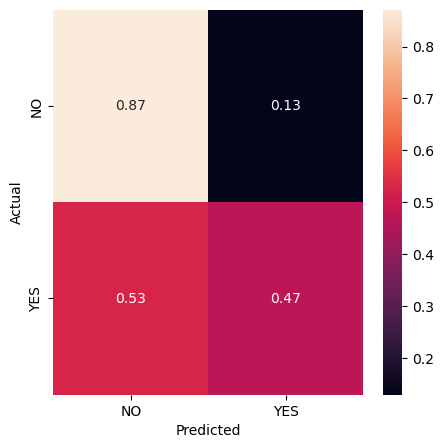

In [102]:
ab_clf_base = AdaBoostClassifier(random_state=42)

pipeline_ada_base = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resample", SMOTE(random_state=42)),
        ("model", ab_clf_base),
    ]
)

pipeline_ada_base.fit(X_train, y_train)
pred_y_base_ada = pipeline_ada_base.predict(X_val)

print("\nClassification Report")
print(classification_report(y_val, pred_y_base_ada))
myFunc.confusion_matrix_normalized(y_val, pred_y_base_ada, ["NO", "YES"])

In [103]:
print(
    f"F1 score {f1_score(y_val, pred_y_base_ada).round(2)} and recall {recall_score(y_val, pred_y_base_ada).round(2)} for AdaBoostClassifier basic"
)

F1 score 0.24 and recall 0.47 for AdaBoostClassifier basic


Not good at all. Based on the confusion matrix, it appears that true positives resemble random guesses.

**Tuned AdaBoostClassifier**

Let's employ GridSearch to fine-tune our model and enhance its performance.

In [104]:
# parameters = {
#     "model__n_estimators": [2, 3, 4, 5, 10, 15, 20, 30, 35],
#     "model__learning_rate": [(0.9 + x / 100) for x in range(0, 9)],
#     "model__algorithm": ["SAMME", "SAMME.R"],
# }
# grid = GridSearchCV(
#     pipeline_ada_base, param_grid=parameters, cv=5, verbose=10, n_jobs=-1, scoring="f1"
# )
# result = grid.fit(X_train, y_train)
# print(f"Best params:")
# print(result.best_params_)
# print()
# print("Best f1 score in randomized search:")
# print(result.best_score_)

Best params:
{'model__algorithm': 'SAMME.R', 'model__learning_rate': 0.93, 'model__n_estimators': 30}

Best f1 score in randomized search:
0.24245888073798366

**Tuned AdaBoostClassifier**


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       729
           1       0.13      0.55      0.21        38

    accuracy                           0.80       767
   macro avg       0.55      0.68      0.55       767
weighted avg       0.93      0.80      0.85       767



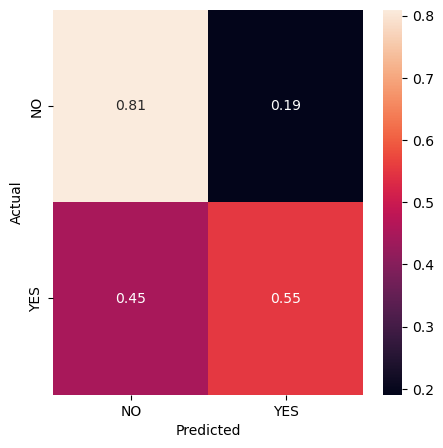

In [105]:
ab_clf_tuned = AdaBoostClassifier(
    algorithm="SAMME.R", learning_rate=0.93, n_estimators=30, random_state=42
)

pipeline_ada_tuned = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resample", SMOTE(random_state=42)),
        ("model", ab_clf_tuned),
    ]
)
pipeline_ada_tuned.fit(X_train, y_train)
pred_h_ada = pipeline_ada_tuned.predict(X_val)

print("\nClassification Report")
print(classification_report(y_val, pred_h_ada))
myFunc.confusion_matrix_normalized(y_val, pred_h_ada, ["NO", "YES"])

In [106]:
print(
    f"F1 score {f1_score(y_val, pred_h_ada).round(2)} and recall {recall_score(y_val, pred_h_ada).round(2)} for AdaBoostClassifier tuned"
)

F1 score 0.21 and recall 0.55 for AdaBoostClassifier tuned


We see, that our True positives are pradicted much better.  

# Support vector machine (rbf)

**Basic SVM(rbf)**

Let's assess the results we can obtain with a basic SVM (rbf) on the validation dataset.


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       729
           1       0.14      0.58      0.23        38

    accuracy                           0.81       767
   macro avg       0.56      0.70      0.56       767
weighted avg       0.93      0.81      0.86       767



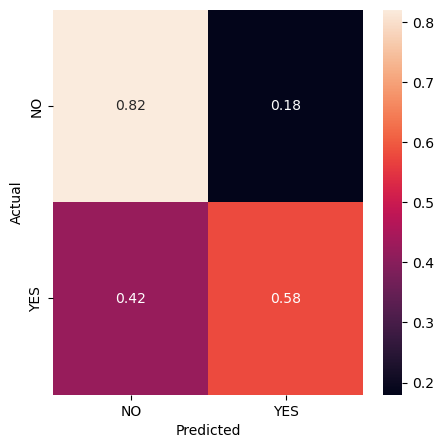

In [107]:
SVM_clf_base = SVC(kernel="rbf")

pipeline_SVC_base = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resample", SMOTE(random_state=42)),
        ("model", SVM_clf_base),
    ]
)

pipeline_SVC_base.fit(X_train, y_train)
pred_y_base_SVC = pipeline_SVC_base.predict(X_val)

print("\nClassification Report")
print(classification_report(y_val, pred_y_base_SVC))
myFunc.confusion_matrix_normalized(y_val, pred_y_base_SVC, ["NO", "YES"])

Basic SVC(rbf) is doing better than tuned AdaBoostClassifier.  

In [108]:
print(
    f"F1 score {f1_score(y_val, pred_y_base_SVC).round(2)} and recall {recall_score(y_val, pred_y_base_SVC).round(2)} for SVC(rbf) basic"
)

F1 score 0.23 and recall 0.58 for SVC(rbf) basic


**Tuned SVC(rbf)**

Let's employ GridSearch to fine-tune our model and enhance its performance.

In [109]:
# parameters = {
#     "model__C": [0.1, 1, 10, 100, 1000],
#     "model__kernel": ["rbf"],
#     "model__gamma": [10, 1, 0.1, 0.01],
#     "model__class_weight": ["balanced", None],
# }
# grid = GridSearchCV(
#     pipeline_SVC_base, param_grid=parameters, cv=5, n_jobs=-1, scoring="f1"
# )
# result = grid.fit(X_train, y_train)
# print(f"Best params:")
# print(result.best_params_)
# print()
# print("Best f1 score in randomized search:")
# print(result.best_score_)

Best params:
{'model__C': 1, 'model__class_weight': 'balanced', 'model__gamma': 0.1, 'model__kernel': 'rbf'}

Best f1 score in randomized search:
0.2252907429849441

**Tuned AdaBoostClassifier**


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       729
           1       0.14      0.58      0.23        38

    accuracy                           0.81       767
   macro avg       0.56      0.70      0.56       767
weighted avg       0.93      0.81      0.86       767



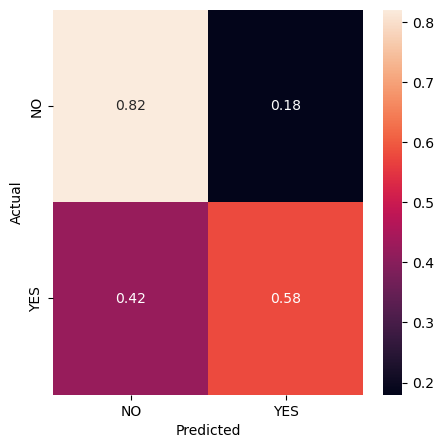

In [110]:
SVC_clf_tuned = SVC(C=1, gamma=0.1, kernel="rbf", class_weight="balanced")

pipeline_SVM_tuned = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resample", SMOTE(random_state=42)),
        ("model", SVC_clf_tuned),
    ]
)
pipeline_SVM_tuned.fit(X_train, y_train)
pred_h_SVM = pipeline_SVM_tuned.predict(X_val)

print("\nClassification Report")
print(classification_report(y_val, pred_h_SVM))
myFunc.confusion_matrix_normalized(y_val, pred_h_SVM, ["NO", "YES"])

Tuning made no effect at all.  

In [111]:
print(
    f"F1 score {f1_score(y_val, pred_h_SVM).round(2)} and recall {recall_score(y_val, pred_h_SVM).round(2)} for SVC(rbf) tuned"
)

F1 score 0.23 and recall 0.58 for SVC(rbf) tuned


# Random forest

**Basic Random forest**

Let's assess the results we can obtain with a basic random forest on the validation dataset.


Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       729
           1       0.18      0.11      0.13        38

    accuracy                           0.93       767
   macro avg       0.57      0.54      0.55       767
weighted avg       0.92      0.93      0.92       767



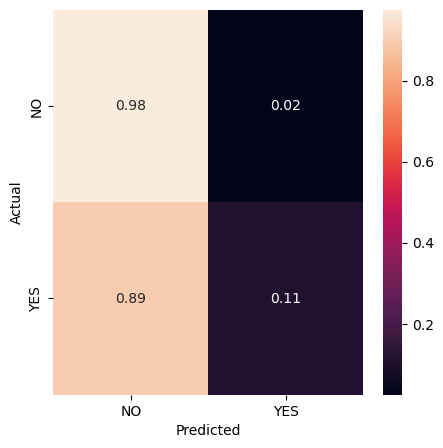

In [112]:
RF_clf_base = RandomForestClassifier()

pipeline_RF_base = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resample", SMOTE(random_state=42)),
        ("model", RF_clf_base),
    ]
)

pipeline_RF_base.fit(X_train, y_train)
pred_y_base_RF = pipeline_RF_base.predict(X_val)

print("\nClassification Report")
print(classification_report(y_val, pred_y_base_RF))
myFunc.confusion_matrix_normalized(y_val, pred_y_base_RF, ["NO", "YES"])

Very bad. Most of the times, model predicts No stroke.  

In [113]:
print(
    f"F1 score {f1_score(y_val, pred_y_base_RF).round(2)} and recall {recall_score(y_val, pred_y_base_RF).round(2)} for RandomForest basic"
)

F1 score 0.13 and recall 0.11 for RandomForest basic


**Tuned Random forest**

Let's employ GridSearch to fine-tune our model and enhance its performance.

In [114]:
# parameters = {
#     "model__n_estimators": [100, 500, 1000],
#     "model__max_depth": [1, 5, 10, 25],
#     "model__max_features": [*np.arange(0.1, 1.1, 0.1)],
# }
# grid = GridSearchCV(
#     pipeline_RF_base, param_grid=parameters, cv=5, n_jobs=-1, scoring="f1"
# )
# result = grid.fit(X_train, y_train)
# print(f"Best params:")
# print(result.best_params_)
# print()
# print("Best f1 score in randomized search:")
# print(result.best_score_)

Best params:
{'model__max_depth': 5, 'model__max_features': 0.8, 'model__n_estimators': 100}

Best f1 score in randomized search:
0.2289194903310256

**Tuned RandomForest**


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       729
           1       0.15      0.71      0.24        38

    accuracy                           0.78       767
   macro avg       0.56      0.75      0.56       767
weighted avg       0.94      0.78      0.84       767



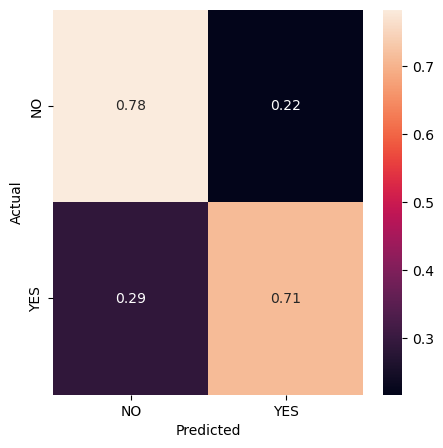

In [115]:
RF_clf_tuned = RandomForestClassifier(n_estimators=100, max_depth=5, max_features=0.8)

pipeline_RF_tuned = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resample", SMOTE(random_state=42)),
        ("model", RF_clf_tuned),
    ]
)
pipeline_RF_tuned.fit(X_train, y_train)
pred_h_RF = pipeline_RF_tuned.predict(X_val)

print("\nClassification Report")
print(classification_report(y_val, pred_h_RF))
myFunc.confusion_matrix_normalized(y_val, pred_h_RF, ["NO", "YES"])

Tuning had a significant impact on the scores, resulting in the best results achieved so far!  

In [116]:
print(
    f"F1 score {f1_score(y_val, pred_h_RF).round(2)} and recall {recall_score(y_val, pred_h_RF).round(2)} for RandomForest tuned"
)

F1 score 0.24 and recall 0.71 for RandomForest tuned


**Summary for best 3 models**

In [117]:
print(
    f"F1 score {f1_score(y_val, pred_y_base_ada).round(2)} and recall {recall_score(y_val, pred_y_base_ada).round(2)} for AdaBoostClassifier basic"
)
print(
    f"F1 score {f1_score(y_val, pred_h_ada).round(2)} and recall {recall_score(y_val, pred_h_ada).round(2)} for AdaBoostClassifier tuned"
)
print(
    f"F1 score {f1_score(y_val, pred_y_base_SVC).round(2)} and recall {recall_score(y_val, pred_y_base_SVC).round(2)} for SVC(rbf) basic"
)
print(
    f"F1 score {f1_score(y_val, pred_h_SVM).round(2)} and recall {recall_score(y_val, pred_h_SVM).round(2)} for SVC(rbf) tuned"
)
print(
    f"F1 score {f1_score(y_val, pred_y_base_RF).round(2)} and recall {recall_score(y_val, pred_y_base_RF).round(2)} for RandomForest basic"
)
print(
    f"F1 score {f1_score(y_val, pred_h_RF).round(2)} and recall {recall_score(y_val, pred_h_RF).round(2)} for RandomForest tuned"
)

F1 score 0.24 and recall 0.47 for AdaBoostClassifier basic
F1 score 0.21 and recall 0.55 for AdaBoostClassifier tuned
F1 score 0.23 and recall 0.58 for SVC(rbf) basic
F1 score 0.23 and recall 0.58 for SVC(rbf) tuned
F1 score 0.13 and recall 0.11 for RandomForest basic
F1 score 0.24 and recall 0.71 for RandomForest tuned


Almost all models yielded nearly identical F1 scores, with RandomForest achieving the highest recall. Now, let's use the test set to determine the final scores.

#### Tuned Random forest on test set


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       729
           1       0.14      0.65      0.22        37

    accuracy                           0.78       766
   macro avg       0.56      0.72      0.55       766
weighted avg       0.94      0.78      0.84       766



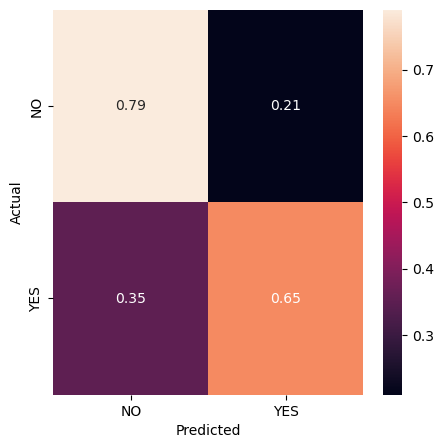

In [118]:
pred_h_RF_test = pipeline_RF_tuned.predict(X_test)

print("\nClassification Report")
print(classification_report(y_test, pred_h_RF_test))
myFunc.confusion_matrix_normalized(y_test, pred_h_RF_test, ["NO", "YES"])

In [119]:
print(
    f"F1 score {f1_score(y_test, pred_h_RF_test).round(2)} and recall {recall_score(y_test, pred_h_RF_test).round(2)} for RandomForest tuned on test set"
)

F1 score 0.22 and recall 0.65 for RandomForest tuned on test set


### Model explanation with SHAP

Now let's explore wich features made the bigest impact on stroke predictions.

**KernelExplainer**

In [120]:
data = shap.sample(preprocessor.fit_transform(X_train), 100)
explainer = shap.KernelExplainer(
    pipeline_RF_tuned["model"].predict_proba, data, link="logit"
)
shap_values = explainer.shap_values(preprocessor.transform(X_val))

  0%|          | 0/767 [00:00<?, ?it/s]

In [121]:
# Get indexes where stroke is True
np.where(y_val == 1)

(array([ 36,  37,  68,  75,  79, 111, 127, 139, 151, 184, 194, 198, 200,
        214, 236, 255, 258, 312, 321, 342, 343, 358, 440, 473, 478, 504,
        515, 523, 533, 558, 608, 662, 680, 708, 709, 711, 715, 752],
       dtype=int64),)

In [122]:
y_val.iloc[36]

1

In [123]:
one_hot = list(
    pipeline_RF_tuned.named_steps["preprocessor"]
    .transformers_[2][1]
    .named_steps["onehot"]
    .get_feature_names_out(one_hot_features)
)

cat_all = (
    ["bmi_times_glucose", "age2_per_bmi"]
    + numerical_features
    + one_hot
    + ordinal_features
)
cat_all

['bmi_times_glucose',
 'age2_per_bmi',
 'bmi',
 'age',
 'avg_glucose_level',
 'work_type_children',
 'work_type_govt_job',
 'work_type_never_worked',
 'work_type_private',
 'work_type_self-employed',
 'gender_female',
 'gender_male',
 'gender_other',
 'hypertension_yes',
 'heart_disease_yes',
 'ever_married_yes',
 'residence_type_urban',
 'smoking_status']

In [124]:
shap.initjs()

shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][36, :],
    preprocessor.transform(X_val)[36, :],
    link="logit",
    feature_names=cat_all,
)

For the 36th instance of the y_val_main set (with an output of 1), SHAP values indicate that the base value was 0.2415, and the predicted probability was 0.66. The features that predominantly increased the probability were age, age2_per_bmi, and BMI. Let's check few more examples: one positive outcome (1), and the other for negative (0).

In [125]:
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][68, :],
    preprocessor.transform(X_val)[68, :],
    link="logit",
    feature_names=cat_all,
)

In [126]:
# negative output example
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][66, :],
    preprocessor.transform(X_val)[68, :],
    link="logit",
    feature_names=cat_all,
)

In [127]:
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1],
    preprocessor.transform(X_val),
    feature_names=cat_all,
)

Now we see results on all validation set for all 767 instances.  
Features mostly increasing the probability of positive outcome (1) were:  
- age, 
- age2_per_bmi 
- bmi

Plot below gives the same results.

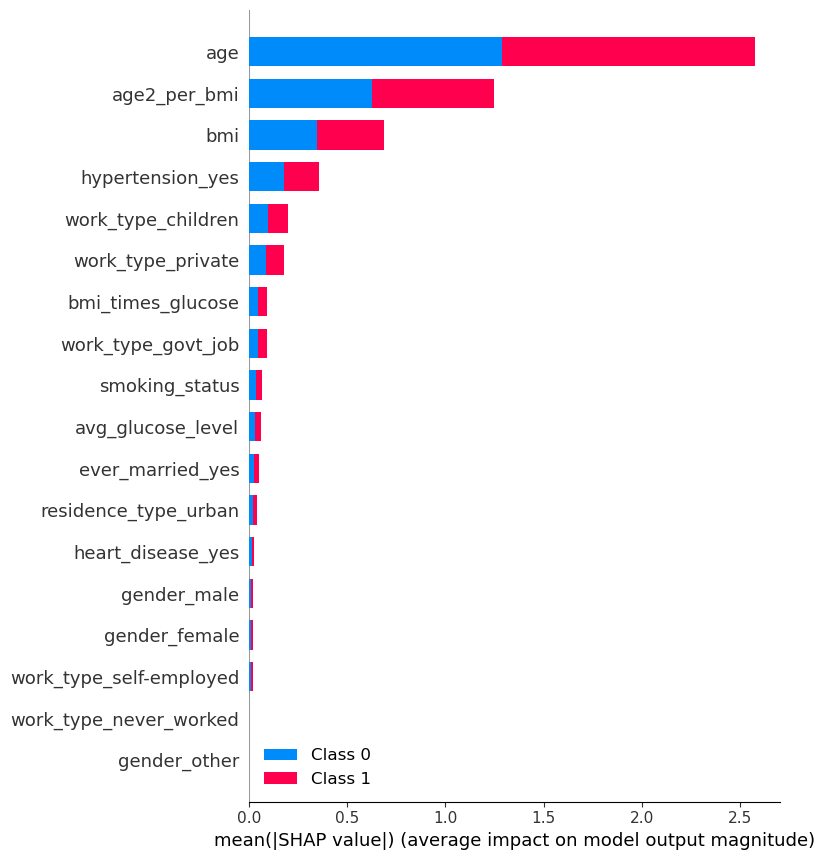

In [128]:
shap.summary_plot(shap_values, feature_names=cat_all, plot_type="bar")

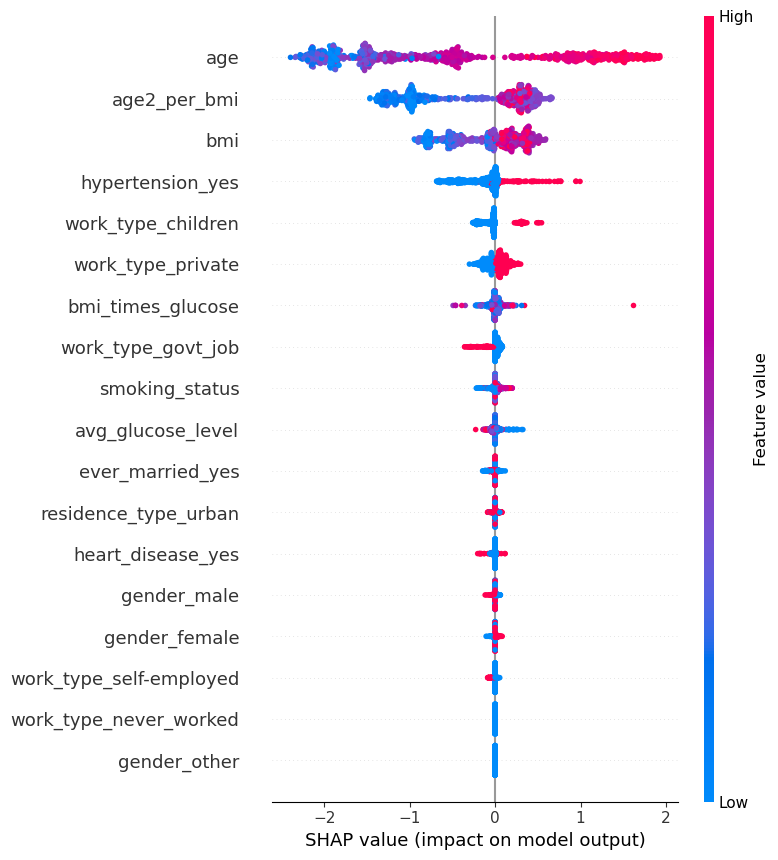

In [129]:
shap.summary_plot(shap_values[1], preprocessor.transform(X_val), feature_names=cat_all)

In [130]:
dump(pipeline_RF_tuned, "stroke_classifier.joblib")

['stroke_classifier.joblib']

## Conclusions:

We have successfully developed an exceptional model for The Johns Hopkins Hospital to predict stroke. The model's recall rate indicates that we can accurately identify nearly 70 percent of patients at risk of a stroke.

Our initial exploratory data analysis (EDA) highlighted the significance of age, hypertencion and BMI as key features in predicting stroke risk. The findings from our model analysis validate these insights. It is imperative that we prioritize and closely monitor these measurements in the future to enhance our ability to identify individuals at risk of stroke promptly.

Suggestions: 
- Continue on feature engineering (look at "additional2_PYCARET with feat eng.ipynb")
- Try more models (look at "additional2_PYCARET with feat eng.ipynb")
- Try different strategies for imbalanced data then SMOTE.

Final model score:

In [131]:
print(
    f"F1 score {f1_score(y_test, pred_h_RF_test).round(2)} and recall {recall_score(y_test, pred_h_RF_test).round(2)} for RandomForest tuned on test set"
)

F1 score 0.22 and recall 0.65 for RandomForest tuned on test set
